## Identifying Credit Card Fraud Transactions

The dataset chosen is a split of train test data from the credit card transactions of a labeled dataset. The objective is to build a model to flag a fraud transaction in the future. This project realises the importance of data pre-processing, feature engineering, handling imabalnced classes through SMOTE, BOrderline SVM SMOTE and compare performance, apply classification models (Random Forest, Gradient Boost Trees), feature importance, hyper-parameter tuning through Bayesian Optimization with HYPEROPT, select appropriate evaluation metric (F1 score, AUC ROC, G-Mean).

##### The following assumptions are listed below which are made to keep the analysis: 
1. The dataset is a simulated version. The credit card numbers are assumed to be 10 characters long.
2. street, zip and city name were found to be unique to the full name of the customer hence, only one column, out of the four is required 
3. There is one and only one person with a complete full name, that is each full name is unique and represents only one customer

In [1]:
import pandas as pd 
import numpy as np 
import os 
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import matplotlib.pyplot as plt 
%matplotlib inline

In [2]:
df = pd.read_csv(".../fraudTrain.csv")

### Data Overview and Cleaning

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 21 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   trans_date_trans_time  1048575 non-null  object 
 1   trans_time             1048575 non-null  object 
 2   cc_num                 1048575 non-null  int64  
 3   merchant               1048575 non-null  object 
 4   category               1048575 non-null  object 
 5   amt                    1048575 non-null  float64
 6   first                  1048575 non-null  object 
 7   last                   1048575 non-null  object 
 8   gender                 1048575 non-null  object 
 9   street                 1048575 non-null  object 
 10  city                   1048575 non-null  object 
 11  state                  1048575 non-null  object 
 12  zip                    1048575 non-null  int64  
 13  city_pop               1048575 non-null  int64  
 14  job               

In [4]:
df.head()

,trans_date_trans_time,trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,state,zip,city_pop,job,dob,trans_num,unix_time,extracted_time,duration_trans,is_fraud
0,01-01-2019,00:00:00,270000000,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,NC,28654,3495,"Psychologist, counselling",09-03-1988,0b242abb623afc578575680df30655b9,1325376018,00:18,00:00:18,0
1,01-01-2019,00:00:00,630000000,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,WA,99160,149,Special educational needs teacher,21-06-1978,1f76529f8574734946361c461b024d99,1325376044,00:44,00:00:44,0
2,01-01-2019,00:00:00,389000000,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,ID,83252,4154,Nature conservation officer,19-01-1962,a1a22d70485983eac12b5b88dad1cf95,1325376051,00:51,00:00:51,0
3,01-01-2019,00:01:00,353000000,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,MT,59632,1939,Patent attorney,12-01-1967,6b849c168bdad6f867558c3793159a81,1325376076,01:16,00:00:16,0
4,01-01-2019,00:03:00,376000000,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,VA,24433,99,Dance movement psychotherapist,28-03-1986,a41d7549acf90789359a9aa5346dcb46,1325376186,03:06,00:00:06,0


In [5]:
#concatenating column 'first' and 'last' to create a new column 'full name'
df['full_name']= df['first']+'_'+df['last']
print(df['full_name'])

0             Jennifer_Banks
1             Stephanie_Gill
2             Edward_Sanchez
3               Jeremy_White
4               Tyler_Garcia
                 ...        
1048570         Haley_Wagner
1048571    Meredith_Campbell
1048572          Susan_Mills
1048573           Julia_Bell
1048574     Shannon_Williams
Name: full_name, Length: 1048575, dtype: object


In [6]:
#it can be observed that the doesnt have any null values. #finding out the unique values for the columns
df[['full_name','zip','state','city','street','trans_num']].nunique()

full_name        956
zip              952
state             51
city             879
street           965
trans_num    1048575
dtype: int64

In [7]:
#dropping columns that are unnecessary
df = df.drop(['street','city','zip','city_pop','unix_time','extracted_time','first','last'], axis=1)

In [8]:
#dropping any duplicates in case
df.drop_duplicates(inplace=True)
df.shape

(1048575, 14)

No duplicates were found in the dataset

In [9]:
#converting necessary columns to datetime
from datetime import datetime
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])
df.rename({'trans_date_trans_time':'transaction_date'},  axis=1, inplace = True)
df['dob'] = pd.to_datetime(df['dob'])

In [10]:
#creating an age column with reference to 2020
now = pd.to_datetime('2020-01-01')
df['dob'] = df['dob'].where(df['dob'] < now, df['dob'] -  np.timedelta64(100, 'Y'))
df['age'] = (now - df['dob']).astype('<m8[Y]') 
df = df.drop(['dob'],axis=1)
print(df['age'])

0          31.0
1          41.0
2          57.0
3          52.0
4          33.0
           ... 
1048570    76.0
1048571    20.0
1048572    67.0
1048573    29.0
1048574    22.0
Name: age, Length: 1048575, dtype: float64


feature scaling for numeric variable: check if min max is closer, then scale 

### Exploratory Data Analysis

In [11]:
#checking the number of fraud labels
fraud_perc = df['is_fraud'].value_counts()
print(fraud_perc)

0    1042569
1       6006
Name: is_fraud, dtype: int64


the class is highly imbalanced 

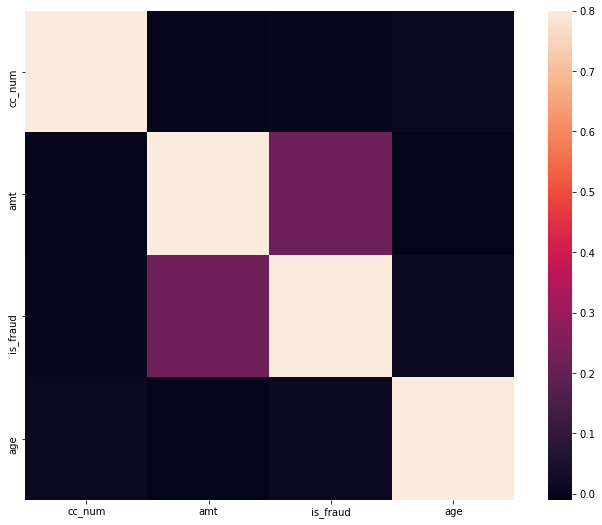

In [12]:
#plotting correlation matrix with features to check their importance
cor = df.corr()
fig = plt.figure(figsize = (12, 9))
sns.heatmap(cor, vmax = .8, square = True)
plt.show()

The relationship of amount and fraud label is much higher

In [13]:
#checking the number of fraud labels
fraud = df[df['is_fraud'] == 1]
valid = df[df['is_fraud'] == 0]

In [14]:
#checking fraud and amt
fraud.amt.describe()

count    6006.000000
mean      530.573492
std       391.333069
min         1.180000
25%       241.577500
50%       391.165000
75%       901.950000
max      1371.810000
Name: amt, dtype: float64

In [15]:
#checking valid and amt
valid.amt.describe()

count    1.042569e+06
mean     6.762744e+01
std      1.536956e+02
min      1.000000e+00
25%      9.600000e+00
50%      4.722000e+01
75%      8.247000e+01
max      2.894890e+04
Name: amt, dtype: float64

#other gradient decent based algos and distance based (KNN, KMeans, SVM) can also be applied but would also require feature scaling ** 

### Data Cleaning

In [16]:
# Import label encoder 
from sklearn.preprocessing import LabelEncoder
# Encode labels
df = df.apply(LabelEncoder().fit_transform)
df

,transaction_date,trans_time,cc_num,merchant,category,amt,gender,state,job,trans_num,duration_trans,is_fraud,full_name,age
0,0,0,22,514,8,397,0,27,370,45701,18,0,409,16
1,0,0,215,241,4,10623,0,47,428,128847,44,0,852,26
2,0,0,77,390,0,21891,1,13,307,662104,51,0,293,42
3,0,1,45,360,2,4400,1,26,328,440259,16,0,428,37
4,0,3,66,297,9,4096,1,45,116,672104,6,0,917,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048570,429,967,207,166,5,7600,0,20,2,286294,29,0,343,61
1048571,429,967,160,110,9,11594,0,12,211,786716,50,0,666,5
1048572,429,968,199,456,6,2027,0,17,175,97489,31,0,871,52
1048573,429,968,141,620,5,852,0,34,193,379398,38,0,495,14


### Train Test Split 
    

In [17]:
from sklearn.model_selection import train_test_split
X = df.drop(['is_fraud'], axis = 1)
y = df['is_fraud']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.30)

### Handing Imbalanced Classes

#### SMOTE

In [18]:
#Performing SMOTE
from collections import Counter
from imblearn.over_sampling import SMOTE
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# summarize class distribution
print(Counter(y_train))

# define undersample strategy
SMOTE = SMOTE()

# fit and apply the transform
X_train_SMOTE, y_train_SMOTE = SMOTE.fit_resample(X_train, y_train)

# summarize class distribution
print(Counter(y_train_SMOTE))

Counter({0: 729810, 1: 4192})
Counter({0: 729810, 1: 729810})


#### Borderline SVM SMOTE

In [19]:
from imblearn.over_sampling import SVMSMOTE
# summarize class distribution
print(Counter(y_train))
sm = SVMSMOTE()
# fit and apply the transform
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)

# summarize class distribution
print(Counter(y_train_sm))

Counter({0: 729794, 1: 4208})
Counter({0: 729794, 1: 729794})


#### ADAYSN

In [20]:
from imblearn.over_sampling import ADASYN

# summarize class distribution
print(Counter(y_train))
ad = ADASYN()
# fit and apply the transform
X_train_ad, y_train_ad = ad.fit_resample(X_train, y_train)

# summarize class distribution
print(Counter(y_train_ad))

Counter({0: 729794, 1: 4208})
Counter({0: 729794, 1: 729391})


the best performing method out of the three can be chosen while evaluating performance

## Fitting into the model 

#### Random Forest (SMOTE)

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import classification_report, roc_auc_score, f1_score

#defing the model 
model= RandomForestClassifier()

#using SMOTE for fitting
clf_SMOTE = model.fit(X_train_SMOTE, y_train_SMOTE)
pred_SMOTE = clf_SMOTE.predict(X_test)

#baseline dataset for fitting
clf = model.fit(X_train, y_train)
pred= clf.predict(X_test)

print("Classification report for oversampled SMOTE data: ", classification_report(y_test, pred_SMOTE))
print("ROC AUC score for oversampled SMOTE data: ", roc_auc_score(y_test, pred_SMOTE))
print("ROC AUC score for (baseline) data: ", roc_auc_score(y_test, pred))

Classification report for oversampled SMOTE data:                precision    recall  f1-score   support

           0       1.00      1.00      1.00    312759
           1       0.64      0.81      0.72      1814

    accuracy                           1.00    314573
   macro avg       0.82      0.90      0.86    314573
weighted avg       1.00      1.00      1.00    314573

ROC AUC score for oversampled SMOTE data:  0.902510420532151
ROC AUC score for (baseline) data:  0.8590823043832605


#### Random Forest (SMOTE SVM)

In [22]:
model= RandomForestClassifier()
clf_sm = model.fit(X_train_sm, y_train_sm)
pred_sm = clf_sm.predict(X_test)

print("Classification report for oversampled SMOTE data: ", classification_report(y_test, pred_sm))
print("ROC AUC score for oversampled SMOTE data: ", roc_auc_score(y_test, pred_sm))
print("ROC AUC score for (baseline) data: ", roc_auc_score(y_test, pred))

Classification report for oversampled SMOTE data:                precision    recall  f1-score   support

           0       1.00      1.00      1.00    312775
           1       0.70      0.80      0.75      1798

    accuracy                           1.00    314573
   macro avg       0.85      0.90      0.87    314573
weighted avg       1.00      1.00      1.00    314573

ROC AUC score for oversampled SMOTE data:  0.8978156637064834
ROC AUC score for (baseline) data:  0.8639596220954037


#### XGB Trees (SMOTE)

In [20]:
#how do you identify max_depth - XGBClassifier(max_depth = 4)
from xgboost import XGBClassifier
model = XGBClassifier()

#using SMOTE for fitting
clf_SMOTE = model.fit(X_train_SMOTE, y_train_SMOTE)
pred_SMOTE = clf_SMOTE.predict(X_test)

#baseline dataset for fitting
clf = model.fit(X_train, y_train)
pred= clf.predict(X_test)

print("Classification report for oversampled SMOTE data: ", classification_report(y_test, pred_SMOTE))
print("ROC AUC score for oversampled SMOTE data: ", roc_auc_score(y_test, pred_SMOTE))
print("ROC AUC score for (baseline) data: ", roc_auc_score(y_test, pred))

Classification report for oversampled SMOTE data:                precision    recall  f1-score   support

           0       1.00      0.99      1.00    312759
           1       0.44      0.86      0.58      1814

    accuracy                           0.99    314573
   macro avg       0.72      0.93      0.79    314573
weighted avg       1.00      0.99      0.99    314573

ROC AUC score for oversampled SMOTE data:  0.9292739289033369
ROC AUC score for (baseline) data:  0.9045235392699253


#### XGB ADASYN

In [24]:
from xgboost import XGBClassifier
xgb = XGBClassifier()

#using SMOTE for fitting
clf_ad = xgb.fit(X_train_ad, y_train_ad)
pred_ad = clf_ad.predict(X_test)

print("Classification report for oversampled SMOTE data: ", classification_report(y_test, pred_ad))
print("ROC AUC score for oversampled SMOTE data: ", roc_auc_score(y_test, pred_ad))
print("ROC AUC score for (baseline) data: ", roc_auc_score(y_test, pred))

Classification report for oversampled SMOTE data:                precision    recall  f1-score   support

           0       1.00      0.99      1.00    312775
           1       0.39      0.86      0.53      1798

    accuracy                           0.99    314573
   macro avg       0.69      0.93      0.77    314573
weighted avg       1.00      0.99      0.99    314573

ROC AUC score for oversampled SMOTE data:  0.9276677084788301
ROC AUC score for (baseline) data:  0.9064669320141768


Since the models above are giving similar scores for SMOTE, Borderline SVM SMOTE and ADASYN, it could be good to go with naive SMOTE due to lesser compution time. Also, xgb gives better results than rf, so we cont with the model and aim to improve it. 

### Getting feature importance from xgb

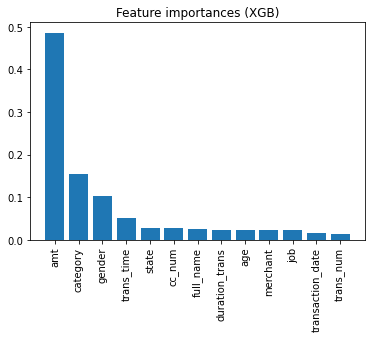

In [25]:
#get feature importances from the model
headers = ["name", "score"]
values = sorted(zip(X_train.columns, xgb.feature_importances_), key=lambda x: x[1] * -1)
xgb_feature_importances = pd.DataFrame(values, columns = headers)

#plot feature importances
x_pos = np.arange(0, len(xgb_feature_importances))
plt.bar(x_pos, xgb_feature_importances['score'])
plt.xticks(x_pos, xgb_feature_importances['name'])
plt.xticks(rotation=90)
plt.title('Feature importances (XGB)')

plt.show()

The most important feature identified are amount transacted, category transacted for, gender of transactioner and transaction time taken

### Hyper Paramter Tuning for the best fit model - xgb

In [26]:
#Initialize domain space for range of values
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': 180,
        'seed': 0
    }

In [27]:
# Define objective function

def objective(space):
    model=XGBClassifier(
                    n_estimators =space['n_estimators'], max_depth = int(space['max_depth']), gamma = space['gamma'],
                    reg_alpha = int(space['reg_alpha']),min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=int(space['colsample_bytree']))
    
      
    model.fit(X_train_SMOTE, y_train_SMOTE)
    pred = model.predict(X_test)
    roc_auc = roc_auc_score(y_test, pred>0.5)
    print ("SCORE:", roc_auc)
    return {'loss': -roc_auc, 'status': STATUS_OK}

In [28]:
#optimisation

trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 50,
                        trials = trials)

SCORE:                                                                                                                 
0.8718508535625469                                                                                                     
SCORE:                                                                                                                 
0.8735885928725324                                                                                                     
SCORE:                                                                                                                 
0.8779721889231359                                                                                                     
SCORE:                                                                                                                 
0.8721748887675175                                                                                                     
SCORE:                                  

In [29]:
#printing best hyperparameters 
print("The best hyperparameters are : ","\n")
print(best_hyperparams)

The best hyperparameters are :  

{'colsample_bytree': 0.868387742357372, 'gamma': 5.687858426453555, 'max_depth': 3.0, 'min_child_weight': 10.0, 'reg_alpha': 151.0, 'reg_lambda': 0.9450231907635458}


### Final Model

In [21]:
from xgboost import XGBClassifier
tuned = XGBClassifier(max_depth = 3, gamma = 5.68, reg_alpha = 151,min_child_weight=10,
                    colsample_bytree=0.86)

#using SMOTE for fitting
clf_SMOTE = tuned.fit(X_train_SMOTE, y_train_SMOTE)
pred_SMOTE = clf_SMOTE.predict(X_test)

#baseline dataset for fitting
clf = tuned.fit(X_train, y_train)
pred= clf.predict(X_test)

print("Classification report for oversampled SMOTE data: ", classification_report(y_test, pred_SMOTE))
print("ROC AUC score for oversampled SMOTE data: ", roc_auc_score(y_test, pred_SMOTE))
print("ROC AUC score for (baseline) data: ", roc_auc_score(y_test, pred))

Classification report for oversampled SMOTE data:                precision    recall  f1-score   support

           0       1.00      0.97      0.99    312759
           1       0.16      0.89      0.28      1814

    accuracy                           0.97    314573
   macro avg       0.58      0.93      0.63    314573
weighted avg       0.99      0.97      0.98    314573

ROC AUC score for oversampled SMOTE data:  0.9319853522379703
ROC AUC score for (baseline) data:  0.7657837378427067


##### END NOTE: XGB model post hyper-parameter tuning with the simple SMOTE over-sampling technique gives the best results with a ROC_AUC score of 93% as opposed to 76% from the baseline data